# An example of using EASYMORE with source netCDF files longitude between 0 to 360 while the target shapefile is from -180 to 180
## Remapping of GRACE to the location of the capital cities around the world

In [1]:
import xarray as xr
import urllib.request
import numpy as np
import pandas as pd
import os
from   datetime import datetime
import time
import hashlib
import requests
from   bs4 import BeautifulSoup

# download GRACE data 
pwd = './temporary/' #
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/mascon/RL06/JPL/v02/CRI/netcdf/'

def GRACE_download(url, pwd): # downlaod and unzip
    
    # 
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # 
    for link in soup.find_all():
        href = link.get("href")
        if href and href.startswith("GRCTellus.JPL.") and href.endswith(".nc"):
            GRACE_name = href
            GRACE_link = url+GRACE_name
        if href and href.startswith("GRCTellus.JPL.") and href.endswith(".nc.md5"):
            md5_link = url+href
            
    if not os.path.isdir(pwd):
        os.makedirs(pwd)
    
    # get the md5
    urllib.request.urlretrieve(md5_link, pwd+'GRACE.nc.md5')
    
    # get the md5 value
    with open(pwd+'GRACE.nc.md5', 'r') as f:
        first_line = f.readline().strip()
        first_line_list = first_line.split()
        md5 = first_line_list[0]

    
    # remove existing file is exists
    if os.path.isfile(pwd+GRACE_name) and hash_file(pwd+GRACE_name) == md5:
        print('It seems the file exists; perhaps perviously downloaded; will skip downloading')
    else:
        # download the file
        print('Downloading GRACE; this may take a while ...')
        print('Downloading starts at: ', datetime.now())
        urllib.request.urlretrieve(GRACE_link, pwd+GRACE_name)
        print('Downloading ends at: ', datetime.now())
        if not (hash_file(pwd+GRACE_name) == md5):
            sys.exit('the file was not downloaded successfully. You can download manually.')
            
    return pwd+GRACE_name


def hash_file(filename):
   """This function returns the MD5 hash
   of the file passed into it"""
   # make a hash object
   h = hashlib.md5()
   # open file for reading in binary mode
   with open(filename,'rb') as file:
       # loop till the end of the file
       chunk = 0
       while chunk != b'':
           chunk = file.read(1024)
           h.update(chunk)
   # return the hex representation of digest
   return h.hexdigest()

# get the link that the file is located

GRACE_file_path = GRACE_download(url, pwd)


It seems the file exists; perhaps perviously downloaded; will skip downloading


In [1]:
# loading EASYMORE
from easymore.easymore import easymore
GRACE_file_path = './temporary/GRCTellus.JPL.200204_202207.GLO.RL06M.MSCNv02CRI.nc'
# initializing EASYMORE object
esmr = easymore()

config     = {'case_name'   : 'capitals_GRACE',
              'temp_dir'    : './temporary/',
              'target_shp'  : './data/target_shapefiles/Capitals_point.shp', # all the world capitals
              'source_nc'   : GRACE_file_path, # ERA5 limited to North America and Caribbean
              'var_names'   : ['lwe_thickness'],
              'var_lon'     : 'lon',
              'var_lat'     : 'lat',
              'var_time'    : 'time',
              'output_dir'  : './output/'}
esmr.init_from_dict(config)

# execute EASYMORE
esmr.nc_remapper()

EASYMORE version 1.0.0 is initiated.
no author name is provided. The author name is changed to (author name)!
EASYMORE will remap variable  lwe_thickness  from source file to variable  lwe_thickness  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dimensions of the variables and latitude and longitude
EASYMORE detects that all the variables have dimensions of:
['time', 'lat', 'lon']
EASYMORE detects that the longitude variables has dimensions of:
['lon']
EASYMORE detects that the latitude variables has dimensions of:
['lat']
--CREATING-REMAPPING-FILE--
Started at date and time 2023-04-11 15:29:15.676094
True
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that no field for ID is provided in sink/target shapefile
arbitarary values of ID are added in the field ID_t
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in 

<xarray.DataArray 'lwe_thickness' (time: 211)>
[211 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2002-04-17T12:00:00 ... 2022-07-16T12:00:00
    ID       float64 182.0
Attributes:
    long_name:  Liquid_Water_Equivalent_Thickness
    units:      cm


<Figure size 1500x500 with 0 Axes>

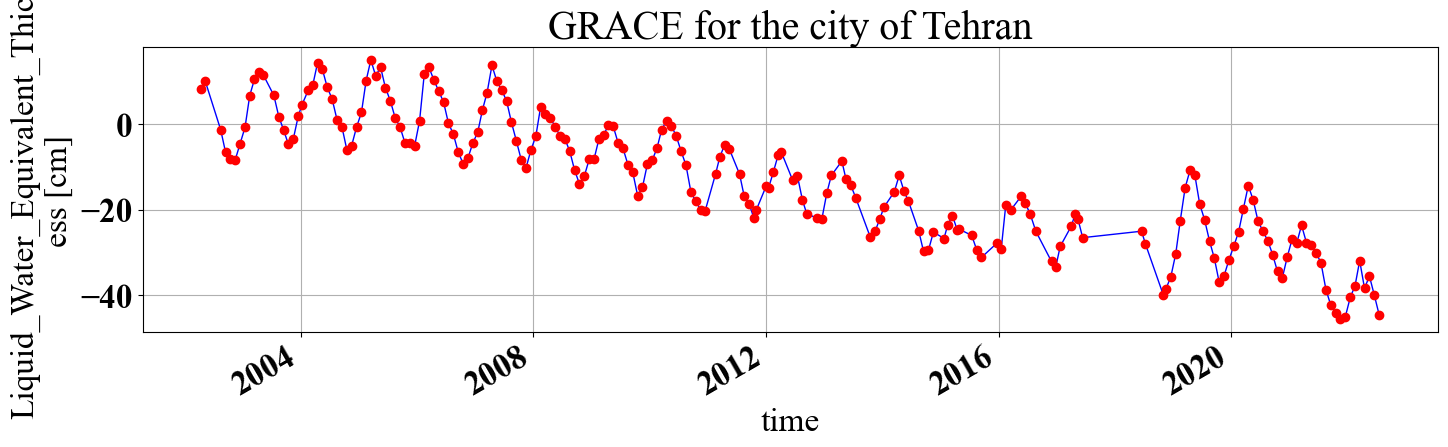

In [2]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

capital_name = 'Tehran'

ds = xr.open_dataset('./output/capitals_GRACE_remapped_2002-04-17-12-00-00.nc')

shp = gpd.read_file('./temporary/capitals_GRACE_target_shapefile.shp')
shp = shp[shp['name']==capital_name] # get the data for given capital

# plot found values from the ID of the city
plt.figure(figsize=(15,5))
ds_slice = ds.sel(ID = shp.ID_t.iloc[0]) # slice the data for the capital
print(ds_slice['lwe_thickness'])

# plot the data
fig, axes = plt.subplots(1,1,figsize=(15,5), facecolor='white')
ds_slice.lwe_thickness.plot(marker='o', color='blue', linewidth=1, markerfacecolor='red',markeredgecolor='red')
plt.grid()
plt.title('GRACE for the city of '+ capital_name)
plt.tight_layout()
plt.savefig('./fig/GRACE_'+capital_name+'.png')
plt.savefig('./fig/GRACE.png')

# # plot found values form the lat lon of the city from the source file
# plt.figure(figsize=(15,5))
# ds = xr.open_dataset(GRACE_file_path)
# if shp.lon_t.iloc[0] > 0:
#     ds_slice = ds.sel(lat = shp.lat_t.iloc[0], lon = shp.lon_t.iloc[0]     , method ='nearest' )
# else:
#     ds_slice = ds.sel(lat = shp.lat_t.iloc[0], lon = shp.lon_t.iloc[0]+ 360, method ='nearest' )
# ds_slice.lwe_thickness.plot()
# plt.grid()
